In [ ]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

import os
import requests
import unicodedata
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from scipy.sparse import hstack

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **EDA**


## Understand Columns Meanings

We want to properly understand what we are dealing with. Particularly, we want to visualize the columns of our dataset and to see their content.
For this reason, we use pandas to read our csv file (the dataset we need to work on) and then we make it so that we can see the various headers.

In [ ]:
path_df = './sms.csv'
sms_df = pd.read_csv(path_df)

In [ ]:
sms_df.head()

,Fraudolent,SMS test,ID,Date and Time
0,0,Squeeeeeze!! This is christmas hug.. If u lik ...,1EWYRBL,2017-12-02
1,0,And also I've sorta blown him off a couple tim...,ZY4PDK7,2018-03-23
2,0,Mmm thats better now i got a roast down me! i...,KLUX2C6,2016-10-29
3,0,Mm have some kanji dont eat anything heavy ok,955HXJ0,2018-04-12
4,0,So there's a ring that comes with the guys cos...,00Q6EUC,2016-08-01


Now we can see all the columns of our dataset and their respective content. This is important, as it will help us to make some relevant decisions later.

## Visualize distribution of the feature of interest

At this point, we are interested in finding out what is the distribution of the *Fraudolent* feature within our dataset. Specifically, we want to see how frequent fraudolent messages are compared to non-fraudolent messages.

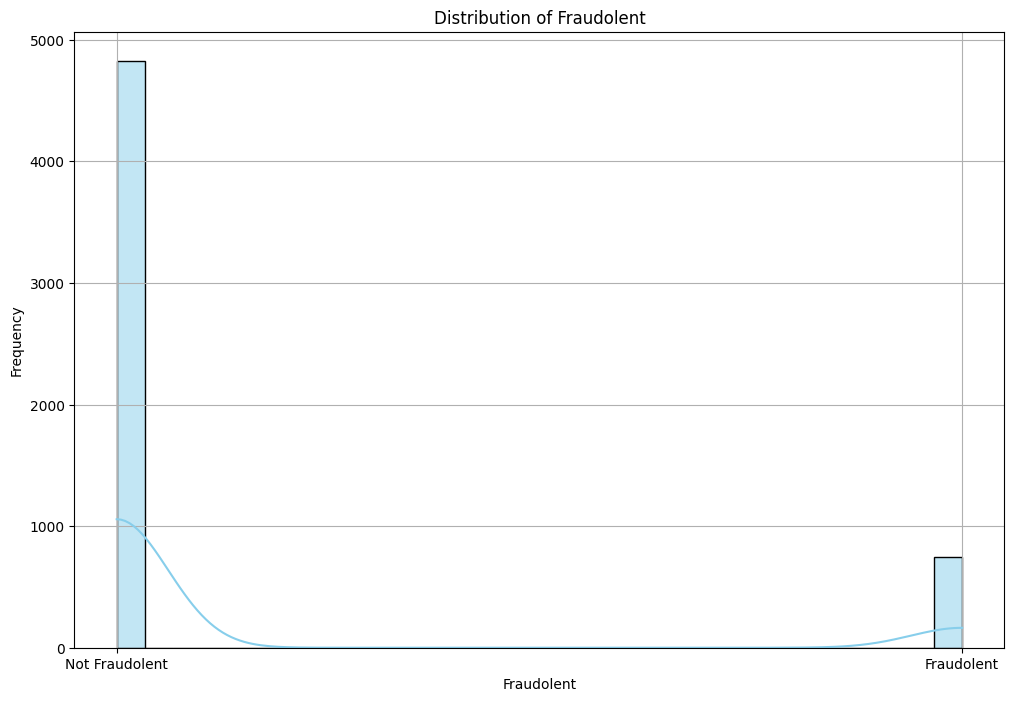

In [ ]:
# Select the column to analyze
column_to_analyze = 'Fraudolent'

# Create a distribution plot (histogram) to visualize the data
plt.figure(figsize=(12, 8))
sns.histplot(sms_df[column_to_analyze], kde=True, bins=30, color='skyblue')
plt.title(f'Distribution of {column_to_analyze}')
plt.xlabel(column_to_analyze)
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Not Fraudolent', 'Fraudolent'])
plt.grid(True)

# Show the plot
plt.show()

From the graph above, we can clearly see that the number of fraudolent messages within our dataset is significantly lower compared to the number of non-fraudolent messages.

## Features' analysis

When dealing with the dataset's features, we need to analyze the ones that we have already seen as columns, as well as the ones that we decided to add (more on this in the preprocessing section).

The first thing that we need to do is to create the additional features that we want to take into consideration. After that, we will analyze said features by creating graphs that will help us to visualize our data.


In [ ]:
df = pd.DataFrame(sms_df)

df['Text Length'] = df['SMS test'].apply(len)

special_chars_lst = ["$","£","%","&","/","*","#","^","+","-","@", "!", "?"]
df['Special Characters'] = df['SMS test'].apply(lambda x: sum(1 for char in x if char in special_chars_lst and not char.isalnum() and not char.isspace()))

df['Num Uppercase'] = df['SMS test'].apply(lambda x: sum(1 for i, char in enumerate(x) if char.isupper() and (i == 0 or not x[i-1].isalpha())))

df['Numeric Count'] = df['SMS test'].apply(lambda x: sum([1 for char in x if char.isnumeric()]))

word_list = ["won","prize", "free", "award", "winner", "urgent", "win", "reward", "text", "call", "reply"]

df['Keywords Count'] = df['SMS test'].apply(lambda x: sum(1 for word in word_list if re.search(fr'\b{word}\b', x, flags=re.IGNORECASE)))


### **Fraudolent & Text Length**

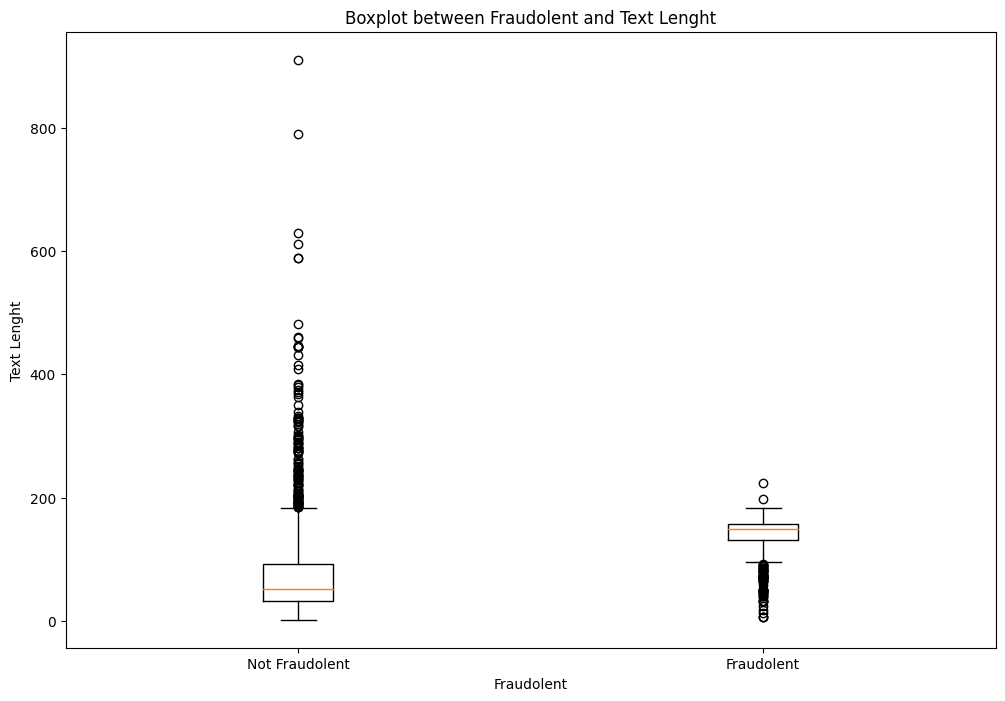

In [ ]:
plt.figure(figsize=(12, 8))
plt.boxplot([df[df['Fraudolent'] == 0]['Text Length'], df[df['Fraudolent'] == 1]['Text Length']],
            labels=['Not Fraudolent', 'Fraudolent'])
plt.title('Boxplot between Fraudolent and Text Lenght')
plt.xlabel('Fraudolent')
plt.ylabel('Text Lenght')
plt.show()

As we can see, non-fraudolent messages are usually less longer than fraudolent messages. The median value of non-fraudolent messages is of about 50 characters. Fraudolent ones, instead, have a value which is slightly smaller than 200.

### **Fraudolent & Special Characters**

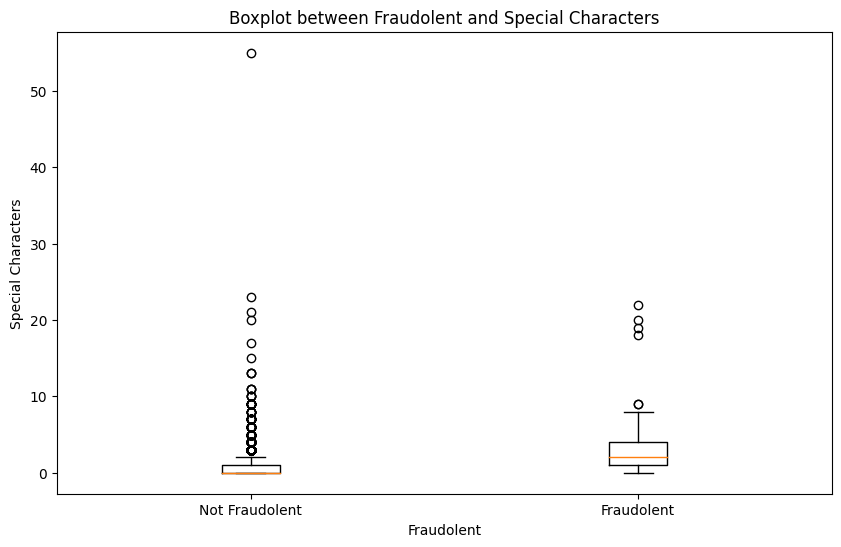

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([df[df['Fraudolent'] == 0]['Special Characters'], df[df['Fraudolent'] == 1]['Special Characters']],
            labels=['Not Fraudolent', 'Fraudolent'])
plt.title('Boxplot between Fraudolent and Special Characters')
plt.xlabel('Fraudolent')
plt.ylabel('Special Characters')
plt.show()

As we can see, non-fraudolent messages usually contains less special characters (eg. "$","£","%","&","/","*","#","^","+","-","@", "!", "?") than fraudolent messages. The median value of non-fraudolent messages is of about 0 special characters. Fraudolent ones, instead, have a value which is of about 3 special characters.

### **Fraudolent & Num Uppercase**

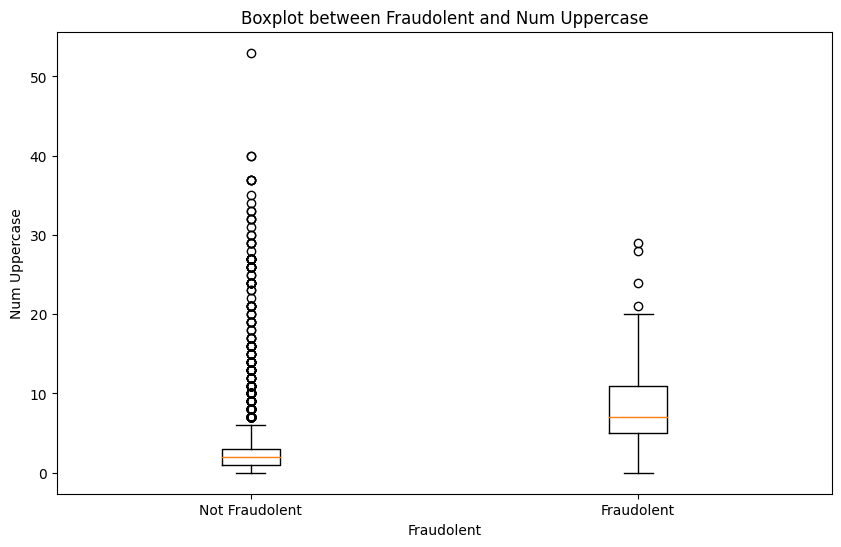

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([df[df['Fraudolent'] == 0]['Num Uppercase'], df[df['Fraudolent'] == 1]['Num Uppercase']],
            labels=['Not Fraudolent', 'Fraudolent'])
plt.title('Boxplot between Fraudolent and Num Uppercase')
plt.xlabel('Fraudolent')
plt.ylabel('Num Uppercase')
plt.show()

As we can see, non-fraudolent messages usually contains less uppercase letters (specifically uppercase letters that are not the first letter of a word) than fraudolent messages. The median value of non-fraudolent messages is of about 3 characters. Fraudolent ones, instead, have a value which is of about 7.

### **Correlation**

Now that we have gathered this information, it is useful to analyze the correlation between all of our features and the feature of interest (*Fraudolent*). In order to do so, we will employ a heatmap, which can be represented as follows:

<ipython-input-9-14b17eac17c9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(sms_df.corr(), annot=True) #corr() -> gives pearson correlation of each column


<Axes: >

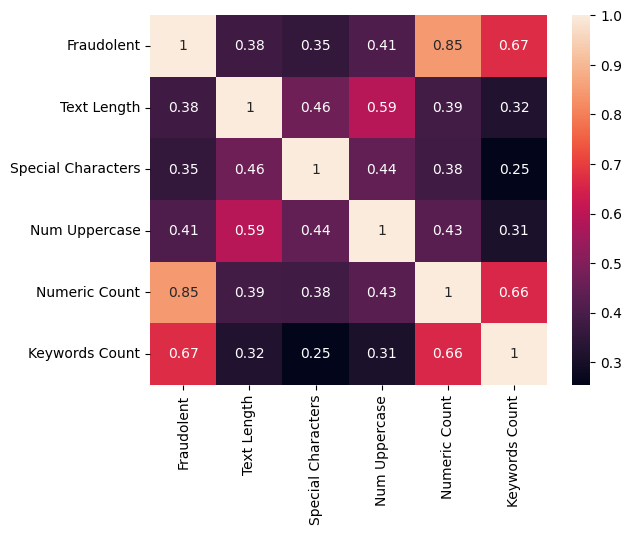

In [ ]:
sns.heatmap(sms_df.corr(), annot=True) #corr() -> gives pearson correlation of each column

From the picture above, we can see that *Numeric Count* and *Keywords Count* are the features with the highest correlation to *Fraudolent* (for more details on the individual features, see the preprocessing section).

In a previous version, there was a feature named *Year*, extracted from *Date and Time*, which was then excluded due to a correlation very close to 0.

# **Preprocessing**

## **1 - Missing values**
We check for missing values within our dataset.

In [ ]:
#Check data integrity
missing_values = sms_df.isnull().sum()

# Display the count of missing values for each column
print("Missing Values Summary:")
print(missing_values)

Missing Values Summary:
Fraudolent            0
SMS test              0
ID                    0
Date and Time         0
Text Length           0
Special Characters    0
Num Uppercase         0
Numeric Count         0
Keywords Count        0
dtype: int64


As we do not have any missing values, we can proceed further.

## **2 - Feature selection and engineering**

When working on a binary classification problem, it is important to identify the most relevant features for the task, starting from the ones provided by our dataset.

After having analyzed the individual features and after having concluded the EDA, we can reach some important conclusions:


*   **Regarding ID**: Considering that the ID is simply used in other to uniquely identify a specific text message, it does not provide any relevant information for classification purposes. Therefore, we can exclude this feature.

*   **Regardind Date and Time**: This feature is also not particularly relevant as shown from the heatmap obtained in the EDA. Specifically, we can see that Fraudolent and Date and Time have in fact a correlation which is close to zero. For this reason, we will exclude this feature as well.

In [ ]:
# To exclude features we use the following piece of code

sms_df = sms_df.drop(columns=['ID','Date and Time'])

In [ ]:
sms_df.head()

,Fraudolent,SMS test,Text Length,Special Characters,Num Uppercase,Numeric Count,Keywords Count
0,0,Squeeeeeze!! This is christmas hug.. If u lik ...,147,4,6,3,0
1,0,And also I've sorta blown him off a couple tim...,116,0,2,0,1
2,0,Mmm thats better now i got a roast down me! i...,102,3,2,1,0
3,0,Mm have some kanji dont eat anything heavy ok,45,0,1,0,0
4,0,So there's a ring that comes with the guys cos...,112,0,3,0,0


Furthermore, to obtain some additional information which might be useful to properly classify text messages, we created some new features, which have already been shown during the EDA. In particular:

*   **Text Length**: Measures the length of the message (in characters). Despite its not so strong correlation to the Fraudolent feature, we still believe it to be an interesting insight.

*   **Special Characters**: Counts the number of special characters contained within a text message. While its correlation to the feature of interest is not so strong, it still is a relevant piece of information for the identification of fraudolent messages.

*   **Num Uppercase**: Counts the total number of uppercase letters in a text message, excluding from the count the first letter of a word. This is because many fraudolent messages tend to incorporate the use of caps lock to stress some words which might pique the interest of the receiver (ex. *You WON a prize*). The correlation between this feature and the feature of interest - according to the heatmap - is not the strongest, but it could be a useful discriminant in the classification process.

*   **Numeric Count**: Counts the number of numeric charactes found in the SMS. This is especially useful, as many fraudolent messages may ask the receiver to call or text a specific phone number. In fact, we can see that the correlation between Numeric Count and Fraudolent is very strong.

*   **Keywords count**: Counts the number of instances in which specific keywords appear within the text, as specific wording choices are very typical of fraudolent message. As expected, it has a pretty strong correlation to the Fraudolent feature.

## **3 - Text preprocessing**
In this dataset, we are dealing with a lot of raw text. Because machine learning models can only work with numerical input features, we firstly need to convert this text into its numerical representation.
However, before that, we have 'prepare' our text for the conversion. In order to do so, we will apply the following steps:

### **Preparation - Dealing with unicode characters**
Our dataset contains accents, diacritic marks and other 'special' symbols, that the machine has a hard time analyzing. Therefore, it is better to normalize the text first.

In [ ]:
def normalize_text(text):
    normalized_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return normalized_text

sms_df['SMS test'] = sms_df['SMS test'].apply(normalize_text)

### **I - Remove URLs from text**
The first step to make our text more uniform is to remove URLs. Basically, we are looking for *http*/*https* and *www*. The reason why we do this, even though URLs are often present in fraudolent message, is to make it so that our models will have less trouble when it comes to generalization.

In [ ]:
# Function to remove URLs from text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

# Apply URL removal to the 'SMS_text' column
sms_df['SMS test'] = sms_df['SMS test'].apply(remove_urls)

### **II - Tokenization**
Our goal at this point is very simple: we want to normalize the text data contained in our SMS test column. In order to do so, it would be better to decompose the content of these various text messages into smaller and more digestible bits. This is exactly what we are doing with tokenization: we are breaking the text into smaller units - known as tokens - that can be individually analyzed and worked with.

In [ ]:
sms_df['SMS test'] = sms_df['SMS test'].apply(word_tokenize)

### **III - Lower Casing**
As the name suggests, this first step has one simple purpose: converting all the text data into lower case. The reason why we do this is to make the text uniform, so that the machine can properly take in all the words provided. Otherwise, words such has *Urgent* and *URGENT* would be considered as different entities.


In [ ]:
sms_df['SMS test'] = sms_df['SMS test'].apply(lambda x: [word.lower() for word in x])

### **IV - Punctuation and special symbols removal**
Now, we are interested in removing punctuation marks and special symbols. The reason for this is always the same: we want to standardize our text.

In [ ]:
sms_df['SMS test'] = sms_df['SMS test'].apply(lambda x: [word for word in x if word.isalnum()])

### **V - Stopwords removal**
Stopwords are defined as a set of commonly used words in a language, such as *a*, *the*, *is*, *are* and so on. Because they do not carry significant information, it is better to remove them.


In [ ]:
stop_words = set(stopwords.words('english'))
sms_df['SMS test'] = sms_df['SMS test'].apply(lambda x: [word for word in x if word not in stop_words])

### **VI - Stemming**
Stemming refers to a process of text standardization, which turns words into their base stem. For example, the stem of *connecting*, *connections* and *connected* is *connect*. It is important in order to lower the dimensionality of our feature and to overall improve generalization.

In [ ]:
stemmer = PorterStemmer()
sms_df['SMS test'] = sms_df['SMS test'].apply(lambda x: [stemmer.stem(word) for word in x])

In [ ]:
sms_df.head()

,Fraudolent,SMS test,Text Length,Special Characters,Num Uppercase,Numeric Count,Keywords Count
0,0,"[squeeeeez, christma, hug, u, lik, frndshp, de...",147,4,6,3,0
1,0,"[also, sorta, blown, coupl, time, recent, id, ...",116,0,2,0,1
2,0,"[mmm, that, better, got, roast, id, b, better,...",102,3,2,1,0
3,0,"[mm, kanji, dont, eat, anyth, heavi, ok]",45,0,1,0,0
4,0,"[ring, come, guy, costum, gift, futur, yowif, ...",112,0,3,0,0


### **VII - 'De-tokenize' our data**
Thanks to all the steps taken until now, we have been able to normalize the text. However, we will soon employ certain tools, which are not able to work with tokens. Therefore, we need to convert everything back to raw text.

In [ ]:
sms_df['SMS test'] = sms_df['SMS test'].apply(lambda x: ' '.join(x))

In [ ]:
sms_df.head()

,Fraudolent,SMS test,Text Length,Special Characters,Num Uppercase,Numeric Count,Keywords Count
0,0,squeeeeez christma hug u lik frndshp den hug b...,147,4,6,3,0
1,0,also sorta blown coupl time recent id rather t...,116,0,2,0,1
2,0,mmm that better got roast id b better drink 2 ...,102,3,2,1,0
3,0,mm kanji dont eat anyth heavi ok,45,0,1,0,0
4,0,ring come guy costum gift futur yowif hint hint,112,0,3,0,0


## **4 - Train test and test set, with vectorization and scaling**
In order to evaluate the performance of our models, it is of primary importance to split the datased into a train set and a test set. In particular, we will employ a stratified split to preserve the proportions of each class of our dataset in the new sets.
In addition, we also need to:

*   **Vectorize** the data contained within SMS test, so that our machine learning models will be able to process it.

*   **Scale numerical data**, so that each feature has a mean of 0 and a standard deviation of 1.

In [ ]:
X = sms_df.drop('Fraudolent', axis=1)
y = sms_df['Fraudolent']

# Perform a stratified split to maintain target variable distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify text and numerical features
text_feature = 'SMS test'
numerical_features = X.columns.difference([text_feature])

# Vectorize text features using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_text = tfidf_vectorizer.fit_transform(X_train[text_feature])
X_test_text = tfidf_vectorizer.transform(X_test[text_feature])

# Scale numerical features using MinMaxScaler
scaler = MinMaxScaler()
X_train_numerical = scaler.fit_transform(X_train[numerical_features])
X_test_numerical = scaler.transform(X_test[numerical_features])

In [ ]:
# Combine vectorized text features and scaled numerical features for training set
X_train_combined = hstack([X_train_text, X_train_numerical])

# Combine vectorized text features and scaled numerical features for testing set
X_test_combined = hstack([X_test_text, X_test_numerical])


# **Models application**

As we have previously pointed out, the task that we want to carry out can be best described as a binary classification problem. Basically, we have some input data and - by analzying the available features - we want to identify this data as either class A or B. In our specific case, we want to find out if a message provided should be classified as fraudolent or not.
Additionally, we are working with a high-dimensional feature (SMS tests), which puts an important restriction to the choice of the model to employ.

All things considered, we decided to apply the following models:


*   **K-nn**
*   **Logistic regression**
*   **Kernelized SVM**
*   **Multilayer perceptron**



## **K-nn**



By default, this model picks five neighbors (basically five data points within the dataset), which are then used for the classification task. Particularly, all the other data points are assigned to  specific class, based on the one of the neighbor that is the closest to them.

In [ ]:
knn_classifier = KNeighborsClassifier()

knn_classifier.fit(X_train_combined, y_train)

y_pred_train = knn_classifier.predict(X_train_combined)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Training set accuracy: {:.6f}".format(accuracy_train))

f1_train_knn = f1_score(y_train, y_pred_train)
print("Training set F1 score (knn): {:.6f}".format(f1_train_knn))

y_pred = knn_classifier.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.6f}".format(accuracy))

f1_test_knn = f1_score(y_pred, y_pred)
print("Test set F1 score (knn): {:.6f}".format(f1_test_knn))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

confusion_knn = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(confusion_knn)

Training set accuracy: 0.938299
Training set F1 score (knn): 0.702703
Test set accuracy: 0.948879
Test set F1 score (knn): 1.000000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       966
           1       1.00      0.62      0.76       149

    accuracy                           0.95      1115
   macro avg       0.97      0.81      0.87      1115
weighted avg       0.95      0.95      0.94      1115


Confusion Matrix:
[[966   0]
 [ 57  92]]


In [ ]:
print("Value of n_neighbors:", knn_classifier.n_neighbors)

Value of n_neighbors: 5


The model does not work well with n_neighboors = 5, in fact the accuracy is pretty low for both training and test set. Recall for fraudolent messages is also very low, in fact there are 57 false negatives.

We also properly depict the confusion matrix that was previously printed.

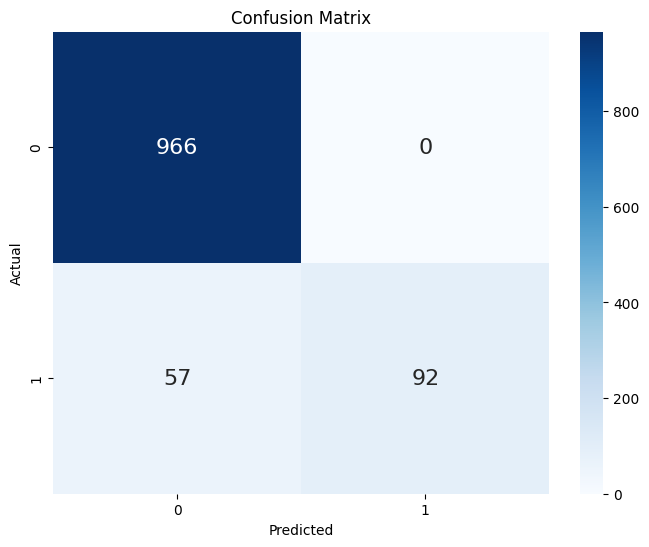

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_knn, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**True Positives**: 92

**True Negatives**: 966

**False Positives**: 0

**False Negatives**: 57



### **Cross validation & hyperparameters tuning**

The hyperparameter that we need to tune for this model is the previously mentioned n_neighbors, which represents the number of data points that are picked as neighbors for the classification process.
Our objective is to identify the appropriate value for this parameter, so that it is not too low - which might cause overfitting - or too high, leading to eccessive generalization.

Now we use the following code to find the best value for n_neighbors.

In [ ]:
k_values = [i for i in range(1, 31)]
scoresknn = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    f1_scorer = make_scorer(f1_score, greater_is_better=True)
    score = cross_val_score(knn, X_train_combined, y_train, cv=5, scoring=f1_scorer)
    scoresknn.append(np.mean(score))

for k, score in zip(k_values, scoresknn):
    print("k = {}, Mean Cross-Validation F1 Score: {:.6f}".format(k, score))

best_k_index = np.argmax(scoresknn)
best_k_value = k_values[best_k_index]

k = 1, Mean Cross-Validation F1 Score: 0.794239
k = 2, Mean Cross-Validation F1 Score: 0.643431
k = 3, Mean Cross-Validation F1 Score: 0.668658
k = 4, Mean Cross-Validation F1 Score: 0.565723
k = 5, Mean Cross-Validation F1 Score: 0.574528
k = 6, Mean Cross-Validation F1 Score: 0.505203
k = 7, Mean Cross-Validation F1 Score: 0.509122
k = 8, Mean Cross-Validation F1 Score: 0.457593
k = 9, Mean Cross-Validation F1 Score: 0.457593
k = 10, Mean Cross-Validation F1 Score: 0.409830
k = 11, Mean Cross-Validation F1 Score: 0.412048
k = 12, Mean Cross-Validation F1 Score: 0.386944
k = 13, Mean Cross-Validation F1 Score: 0.393246
k = 14, Mean Cross-Validation F1 Score: 0.358396
k = 15, Mean Cross-Validation F1 Score: 0.623009
k = 16, Mean Cross-Validation F1 Score: 0.600596
k = 17, Mean Cross-Validation F1 Score: 0.635551
k = 18, Mean Cross-Validation F1 Score: 0.620354
k = 19, Mean Cross-Validation F1 Score: 0.714932
k = 20, Mean Cross-Validation F1 Score: 0.699987
k = 21, Mean Cross-Validation

To better understand these results, we plot them on a graph.

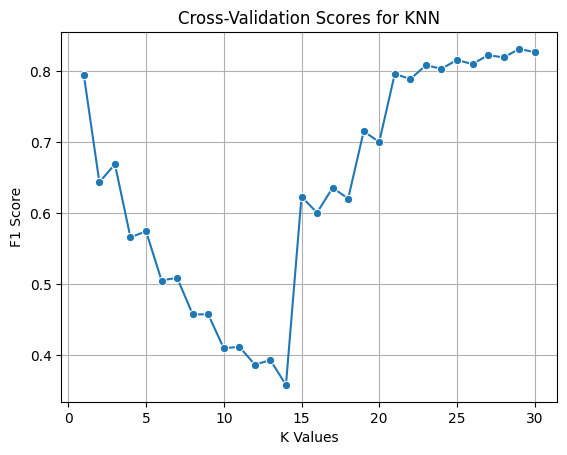

In [ ]:
sns.lineplot(x = k_values, y = scoresknn, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("F1 Score")
plt.title("Cross-Validation Scores for KNN")
plt.grid(True)
plt.show()

As we can see from the graph above, the best value for n_neighbors is 29. We now inject into our model this new piece of information.


In [ ]:
new_n_neighbors = best_k_value
knn_classifier.set_params(n_neighbors=new_n_neighbors)
knn_classifier.fit(X_train_combined, y_train)

y_pred_train = knn_classifier.predict(X_train_combined)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Training set accuracy: {:.6f}".format(accuracy_train))

f1_train_knn = f1_score(y_train, y_pred_train)
print("Training set F1 score (knn): {:.6f}".format(f1_train_knn))

y_pred = knn_classifier.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.6f}".format(accuracy))

f1_test_knn = f1_score(y_pred, y_pred)
print("Test set F1 score (knn): {:.6f}".format(f1_test_knn))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

confusion_knn = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(confusion_knn)

Training set accuracy: 0.958268
Training set F1 score (knn): 0.816206
Test set accuracy: 0.965919
Test set F1 score (knn): 1.000000

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.74      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115


Confusion Matrix:
[[966   0]
 [ 38 111]]


The model's performances have been improved selecting n_neighboors = 29, in fact the accuracy has increased for both training and test set. Recall for fraudolent messages has increased to 85%, in fact there are 38 false negatives.

This is the confusion matrix.

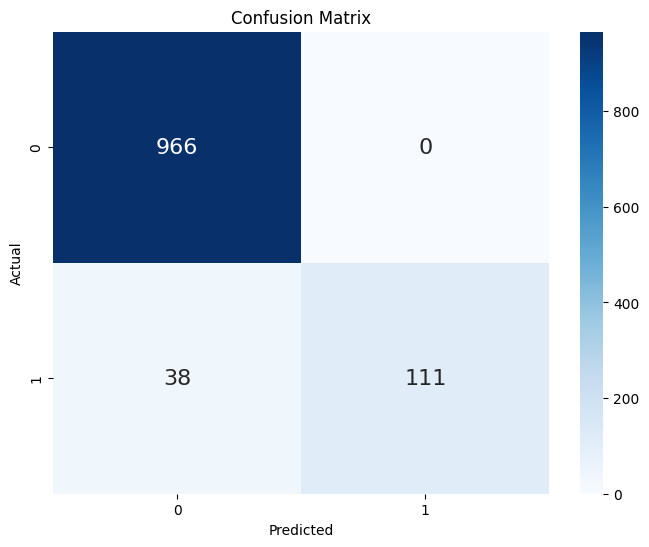

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_knn, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**True Positives**: 111

**True Negatives**: 966

**False Positives**: 0

**False Negatives**: 38


## **Logistic regression**

Logistic Regression is a linear model for binary classification, which predicts the probability of an instance to belong to a particular class based on a linear combination of input features. In particular, according to the result of the function, it separates two classes using a line, a plane, or a hyper‐plane.


In [ ]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train_combined, y_train)

y_pred_train_logreg = logreg_model.predict(X_train_combined)

accuracy_train_logreg = accuracy_score(y_train, y_pred_train_logreg)
print("Training set accuracy (Logistic Regression): {:.6f}".format(accuracy_train_logreg))

f1_train_logreg = f1_score(y_train, y_pred_train_logreg)
print("Training set F1 score (Logistic Regression): {:.6f}".format(f1_train_logreg))

y_pred_test_logreg = logreg_model.predict(X_test_combined)

accuracy_test_logreg = accuracy_score(y_test, y_pred_test_logreg)
print("Test set accuracy (Logistic Regression): {:.6f}".format(accuracy_test_logreg))

f1_test_logreg = f1_score(y_test, y_pred_test_logreg)
print("Test set F1 score (Logistic Regression): {:.6f}".format(f1_test_logreg))

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_test_logreg))

confusion_logreg = confusion_matrix(y_test, y_pred_test_logreg)
print("\nConfusion Matrix (Logistic Regression):")
print(confusion_logreg)

Training set accuracy (Logistic Regression): 0.982724
Training set F1 score (Logistic Regression): 0.931798
Test set accuracy (Logistic Regression): 0.980269
Test set F1 score (Logistic Regression): 0.920863

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.86      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix (Logistic Regression):
[[965   1]
 [ 21 128]]


In [ ]:
print("Value of C:", logreg_model.get_params()['C'])

Value of C: 1.0


The model works well with C = 1 but is quite underfitting (Training set accuracy and Test set accuracy are really close). In addition there is also a false positive. To avoid that we must search for other values of C.


The confusion matrix can be represented as follows:

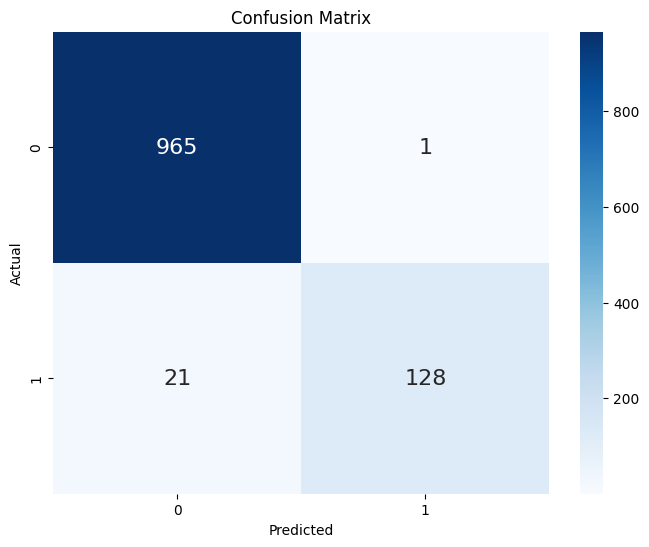

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_logreg, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**True Positives**: 128

**True Negatives**: 965

**False Positives**: 1

**False Negatives**: 21

### **Cross validation & hyperparameters tuning**

In a Logistic Regression model, the C parameter influences the strenght of the applied regularization. A high value of C implies small regularization and higher complexity. Vice versa, a smaller C results in a greater regularization and a lower complexity.

In [ ]:
C_values = np.logspace(-3, 3, 7)
scoresLR = []

for C in C_values:
    logreg_model = LogisticRegression(C=C)
    f1_scorer = make_scorer(f1_score, greater_is_better=True)
    score = cross_val_score(logreg_model, X_train_combined, y_train, cv=5, scoring=f1_scorer)
    scoresLR.append(np.mean(score))

# Find the index of the C value with the highest accuracy
best_CLR_index = np.argmax(scoresLR)
best_CLR_value = C_values[best_CLR_index]

In [ ]:
for C, score in zip(C_values, scoresLR):
    print("C = {:.6f}, Mean Cross-Validation F1 Score: {:.6f}".format(C, score))

C = 0.001000, Mean Cross-Validation F1 Score: 0.000000
C = 0.010000, Mean Cross-Validation F1 Score: 0.016395
C = 0.100000, Mean Cross-Validation F1 Score: 0.775239
C = 1.000000, Mean Cross-Validation F1 Score: 0.906905
C = 10.000000, Mean Cross-Validation F1 Score: 0.938897
C = 100.000000, Mean Cross-Validation F1 Score: 0.944380
C = 1000.000000, Mean Cross-Validation F1 Score: 0.946220


To better visualize the values that we have found, we can use a graph.

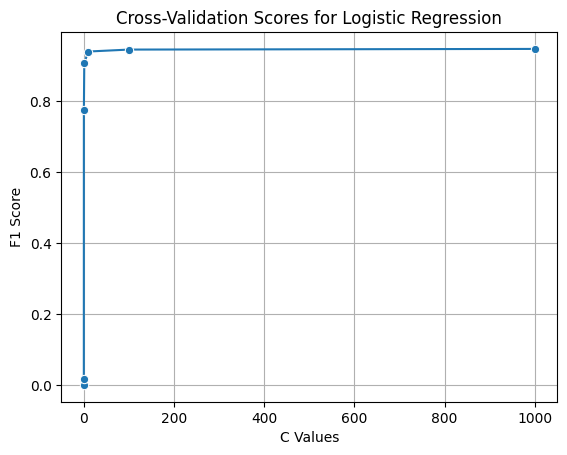

In [ ]:
sns.lineplot(x=C_values, y=scoresLR, marker='o')
plt.xlabel("C Values")
plt.ylabel("F1 Score")
plt.title("Cross-Validation Scores for Logistic Regression")
plt.grid(True)
plt.show()

In [ ]:
new_C = best_CLR_value
logreg_model.set_params(C=new_C)

logreg_model.fit(X_train_combined, y_train)

y_pred_train_logreg = logreg_model.predict(X_train_combined)

accuracy_train_logreg = accuracy_score(y_train, y_pred_train_logreg)
print("Training set accuracy (Logistic Regression): {:.6f}".format(accuracy_train_logreg))

f1_train_logreg = f1_score(y_train, y_pred_train_logreg)
print("Training set F1 score (Logistic Regression): {:.6f}".format(f1_train_logreg))

y_pred_test_logreg = logreg_model.predict(X_test_combined)

accuracy_test_logreg = accuracy_score(y_test, y_pred_test_logreg)
print("Test set accuracy (Logistic Regression): {:.6f}".format(accuracy_test_logreg))

f1_test_logreg = f1_score(y_test, y_pred_test_logreg)
print("Test set F1 score (Logistic Regression): {:.6f}".format(f1_test_logreg))

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_test_logreg))

confusion_logreg = confusion_matrix(y_test, y_pred_test_logreg)
print("\nConfusion Matrix (Logistic Regression):")
print(confusion_logreg)

Training set accuracy (Logistic Regression): 1.000000
Training set F1 score (Logistic Regression): 1.000000
Test set accuracy (Logistic Regression): 0.991031
Test set F1 score (Logistic Regression): 0.965278

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       1.00      0.93      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115


Confusion Matrix (Logistic Regression):
[[966   0]
 [ 10 139]]


With C = 1000 results are very good. The model overfits a bit (Training set accuracy = 1) but the accuracy on the test set is really high (99%). There is no more a false positive and the number of false negatives is decrased to 10, which is just the 7% of the total.

And this is the confusion matrix:

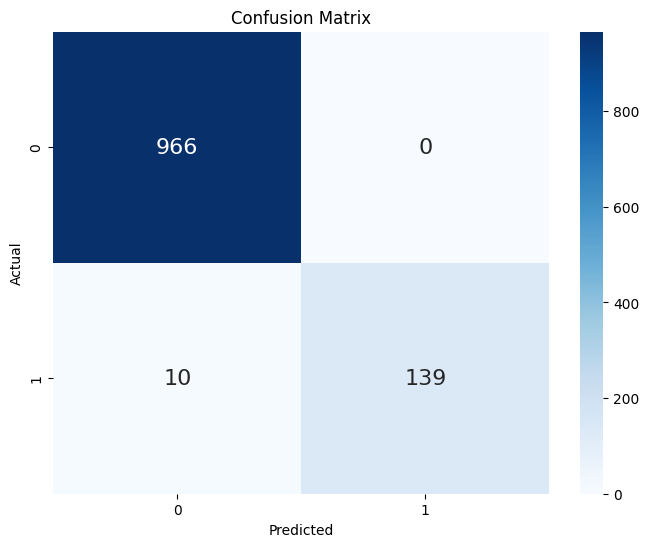

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_logreg, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**True Positives**: 139

**True Negatives**: 966

**False Positives**: 0

**False Negatives**: 10

## **Kernelized SVM**

Kernelized SVM is an algorithm for classification, that identifies the optimal hyperplane to effectively separate the two classes. To achieve this, SVMs employ a kernel function to map the input data into a higher-dimensional space, allowing an efficient identification complex relationships.

In [ ]:
svm_model = SVC(kernel='rbf')

svm_model.fit(X_train_combined, y_train)

y_pred_train_svm = svm_model.predict(X_train_combined)

accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
print("Training set accuracy (SVM): {:.6f}".format(accuracy_train_svm))

f1_train_svm = f1_score(y_train, y_pred_train_svm)
print("Test set F1 score (SVM): {:.6f}".format(f1_train_svm))

y_pred_test_svm = svm_model.predict(X_test_combined)

accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)
print("Test set accuracy (SVM): {:.6f}".format(accuracy_test_svm))

f1_test_svm = f1_score(y_test, y_pred_test_svm)
print("Test set F1 score (SVM): {:.6f}".format(f1_test_svm))

print("\nClassification Report (SVM):")
print(classification_report(y_test, y_pred_test_svm))

confusion_svm = confusion_matrix(y_test, y_pred_test_svm)
print("\nConfusion Matrix (SVM):")
print(confusion_svm)


Training set accuracy (SVM): 0.996635
Test set F1 score (SVM): 0.987320
Test set accuracy (SVM): 0.982063
Test set F1 score (SVM): 0.928058

Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix (SVM):
[[966   0]
 [ 20 129]]


In [ ]:
print("Value of C:", svm_model.get_params()['C'])
print("Value of gamma:", svm_model._gamma)

Value of C: 1.0
Value of gamma: 0.9203139328816125


The model works well with C = 1 and gamma = 0.9203139328816125 but there are 10 more false negatives than the logistic regression's ones. To improve the results we need to tune the hypervalues.

The confusion matrix for this model is as follows:

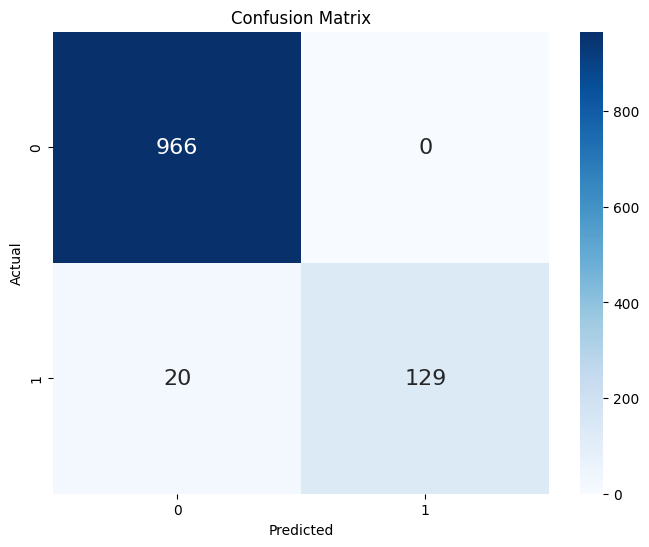

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_svm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**True Positives**: 129

**True Negatives**: 966

**False Positives**: 0

**False Negatives**: 20

### **Cross validation & hyperparameters tuning**

For this model, we will be working on two different hyperparameters: C and gamma. While the C parameter is like the one that we have seen for Logistic Regression, gamma is different: it controls the width of the Gaussian kernel. In practice, this means that, with a small gamma, many points will be considered close, resulting in a lower complexity. The opposite is true with high values of gamma.

Firstly, we look for the best value for C.

In [ ]:
C_values = np.logspace(-3, 3, 7)
scoresSVM = []


for C in C_values:
    svm_model = SVC(kernel='rbf', C=C)
    f1_scorer = make_scorer(f1_score, greater_is_better=True)
    score = cross_val_score(svm_model, X_train_combined, y_train, cv=5, scoring=f1_scorer)
    scoresSVM.append(np.mean(score))

# Find the index of the C value with the highest accuracy
best_CSVM_index = np.argmax(scoresSVM)
best_CSVM_value = C_values[best_CSVM_index]

In [ ]:
for C, score in zip(C_values, scoresSVM):
    print(f"F1 for C={C}: {score}")

F1 for C=0.001: 0.0
F1 for C=0.01: 0.0
F1 for C=0.1: 0.8509121617752229
F1 for C=1.0: 0.9349319936394173
F1 for C=10.0: 0.9405090949437197
F1 for C=100.0: 0.9405090949437197
F1 for C=1000.0: 0.9405090949437197


To better visualize the values that we have found, we can use a graph.

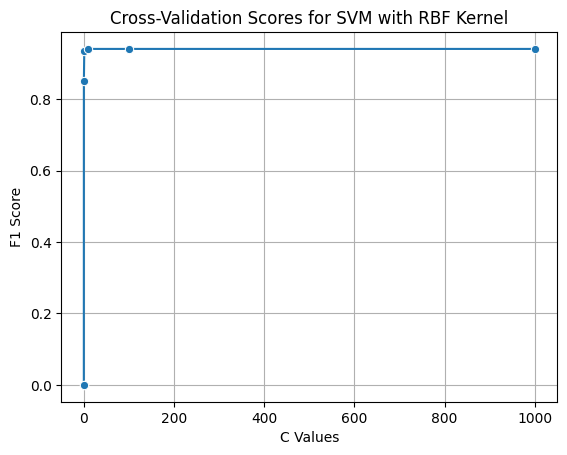

In [ ]:
sns.lineplot(x=C_values, y=scoresSVM, marker='o')
plt.xlabel("C Values")
plt.ylabel("F1 Score")
plt.title("Cross-Validation Scores for SVM with RBF Kernel")
plt.grid(True)
plt.show()

In [ ]:
new_C_svm = best_CSVM_value
svm_model.set_params(C=new_C_svm)

svm_model.fit(X_train_combined, y_train)

y_pred_train_svm = svm_model.predict(X_train_combined)

accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
print("Training set accuracy (SVM): {:.6f}".format(accuracy_train_svm))

f1_train_svm = f1_score(y_train, y_pred_train_svm)
print("Test set F1 score (SVM): {:.6f}".format(f1_train_svm))

y_pred_test_svm = svm_model.predict(X_test_combined)

accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)
print("Test set accuracy (SVM): {:.6f}".format(accuracy_test_svm))

f1_test_svm = f1_score(y_test, y_pred_test_svm)
print("Test set F1 score (SVM): {:.6f}".format(f1_test_svm))

print("\nClassification Report (SVM):")
print(classification_report(y_test, y_pred_test_svm))

confusion_svm = confusion_matrix(y_test, y_pred_test_svm)
print("\nConfusion Matrix (SVM):")
print(confusion_svm)

Training set accuracy (SVM): 1.000000
Test set F1 score (SVM): 1.000000
Test set accuracy (SVM): 0.983857
Test set F1 score (SVM): 0.935714

Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.88      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix (SVM):
[[966   0]
 [ 18 131]]


With C = 10 the performances on the test set has improved slightly but the model is overfitting (Training set accuracy = 1). False negatives decreased by 2.

Now, we look for the best value for gamma.

In [ ]:
gamma_values = np.logspace(-3, 3, 7)
default_gamma = 0.9203021013850465
gamma_values = np.append(gamma_values, default_gamma) #We add the default value of gamma to compare it with the others.
scoresSVM = []


for gamma in gamma_values:
    svm_model = SVC(kernel='rbf', gamma=gamma)
    f1_scorer = make_scorer(f1_score, greater_is_better=True)
    score = cross_val_score(svm_model, X_train_combined, y_train, cv=5, scoring=f1_scorer)
    scoresSVM.append(np.mean(score))

# Find the index of the gamma value with the highest accuracy
best_gammaSVM_index = np.argmax(scoresSVM)
best_gammaSVM_value = gamma_values[best_gammaSVM_index]

In [ ]:
for gamma, score in zip(gamma_values, scoresSVM):
    print("Gamma = {:.6f}, Mean Cross-Validation F1 Score: {:.6f}".format(gamma, score))

Gamma = 0.001000, Mean Cross-Validation F1 Score: 0.000000
Gamma = 0.010000, Mean Cross-Validation F1 Score: 0.816260
Gamma = 0.100000, Mean Cross-Validation F1 Score: 0.912013
Gamma = 1.000000, Mean Cross-Validation F1 Score: 0.933077
Gamma = 10.000000, Mean Cross-Validation F1 Score: 0.354284
Gamma = 100.000000, Mean Cross-Validation F1 Score: 0.338445
Gamma = 1000.000000, Mean Cross-Validation F1 Score: 0.333924
Gamma = 0.920302, Mean Cross-Validation F1 Score: 0.934932


To better visualize the values that we have found, we can use a graph.

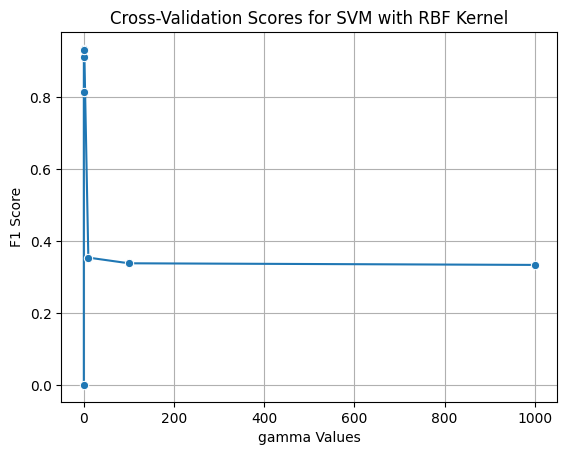

In [ ]:
sns.lineplot(x=gamma_values, y=scoresSVM, marker='o')
plt.xlabel("gamma Values")
plt.ylabel("F1 Score")
plt.title("Cross-Validation Scores for SVM with RBF Kernel")
plt.grid(True)
plt.show()

The default value of gamma is the best so we do not change that.

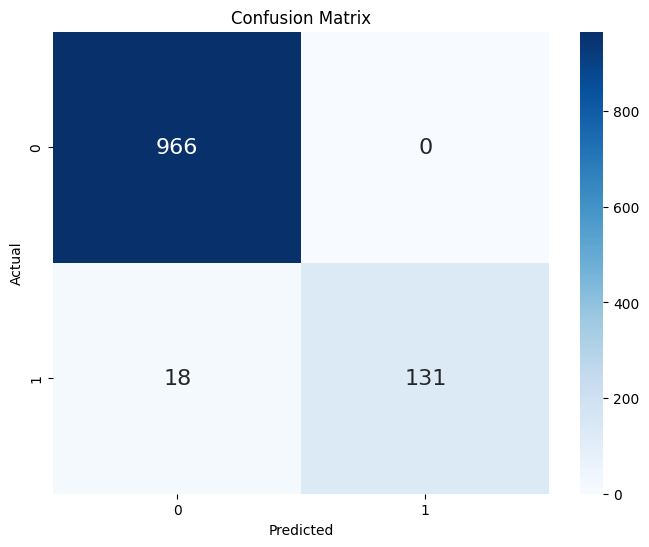

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_svm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**True Positives**: 131

**True Negatives**: 966

**False Positives**: 0

**False Negatives**: 18

## **Multilayer Perceptron**

The Multilayer Perceptron is a class of neural networks for complex pattern recognition tasks. It consists of multiple layers of interconnected nodes (input layer, output layer, hidden layer, etc.) which  receive and process data, with the classification being performed by the output layer.

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

mlp_model.fit(X_train_combined, y_train)

y_pred_train_mlp = mlp_model.predict(X_train_combined)

accuracy_train = accuracy_score(y_train, y_pred_train_mlp)
print("Training set accuracy: {:.6f}".format(accuracy_train))

f1_train_mlp = f1_score(y_train, y_pred_train_mlp)
print("Train set F1 score (MLP): {:.6f}".format(f1_train_mlp))

y_pred_test_mlp = mlp_model.predict(X_test_combined)

accuracy_test = accuracy_score(y_test, y_pred_test_mlp)
print("Test set accuracy: {:.6f}".format(accuracy_test))

f1_test_mlp = f1_score(y_test, y_pred_test_mlp)
print("Test set F1 score (MLP): {:.6f}".format(f1_test_mlp))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test_mlp))

confusion_mlp = confusion_matrix(y_test, y_pred_test_mlp)
print("\nConfusion Matrix (Test Set):")
print(confusion_mlp)

Training set accuracy: 1.000000
Train set F1 score (MLP): 1.000000
Test set accuracy: 0.991928
Test set F1 score (MLP): 0.969072

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       966
           1       0.99      0.95      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115


Confusion Matrix (Test Set):
[[965   1]
 [  8 141]]


In [ ]:
print("Value of alpha:", mlp_model.alpha)

Value of alpha: 0.0001


With alpha = 0.0001 the model works really well. The model overfits a bit (Training set accuracy = 1) but the accuracy on the test set is really high (99%). There is a false positive. To avoid that we have to tune alpha.

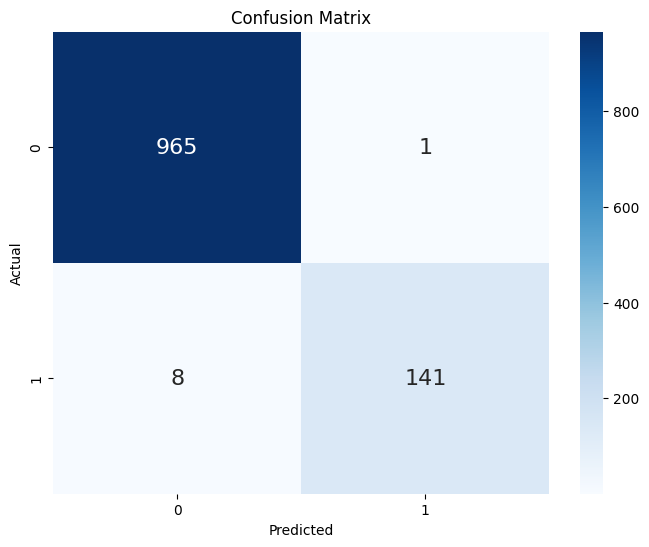

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mlp, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**True Positives**: 141

**True Negatives**: 965

**False Positives**: 1

**False Negatives**: 8

(This results may vary due to the presents of a random state)

### **Cross validation & hyperparameters tuning**

In order to regulate the complexity of this model, we can tune a specific parameter, associated to the so called *l2 penalty*: alpha. Increasing the value of this parameter leads to an increased regularization, reducing the model's complexity.

In [ ]:
alpha_values = np.logspace(-5, 3, 9)
scoresMLP = []

for alpha in alpha_values:
    mlp_model = MLPClassifier(alpha=alpha)
    f1_scorer = make_scorer(f1_score, greater_is_better=True)
    score = cross_val_score(mlp_model, X_train_combined, y_train, cv=5, scoring=f1_scorer)
    scoresMLP.append(np.mean(score))

# Find the index of the best alpha value
best_alphaMLP_index = np.argmax(scoresMLP)
best_alphaMLP_value = alpha_values[best_alphaMLP_index]

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
for alpha, score in zip(alpha_values, scoresMLP):
    print("Alpha = {:.6f}, Mean Cross-Validation F1 Score: {:.6f}".format(alpha, score))

Alpha = 0.000010, Mean Cross-Validation F1 Score: 0.949950
Alpha = 0.000100, Mean Cross-Validation F1 Score: 0.950010
Alpha = 0.001000, Mean Cross-Validation F1 Score: 0.948062
Alpha = 0.010000, Mean Cross-Validation F1 Score: 0.948996
Alpha = 0.100000, Mean Cross-Validation F1 Score: 0.940909
Alpha = 1.000000, Mean Cross-Validation F1 Score: 0.899850
Alpha = 10.000000, Mean Cross-Validation F1 Score: 0.000000
Alpha = 100.000000, Mean Cross-Validation F1 Score: 0.000000
Alpha = 1000.000000, Mean Cross-Validation F1 Score: 0.000000


We plot these results to better understand them.

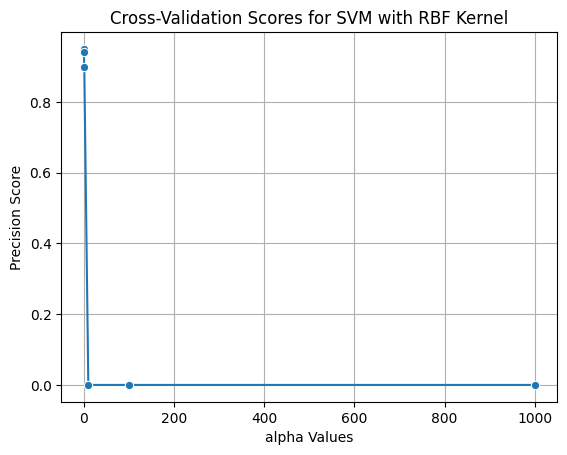

In [ ]:
sns.lineplot(x=alpha_values, y=scoresMLP, marker='o')
plt.xlabel("alpha Values")
plt.ylabel("Precision Score")
plt.title("Cross-Validation Scores for SVM with RBF Kernel")
plt.grid(True)
plt.show()

The default value of alpha is the best so we do not change that.

# **Architecture selection**

Considering what we have said until this point, we believe that the best model for our task is the Logistic Regression model. The main reasons that led us to this decision can be summed up as follows:
*   While the model is quite overfitting - as we can see by looking at the performance on the Training set - the accuracy obtained on the Test set is incredibly good.
*   After tuning the C parameter, we obtain very good results on the classification task, with a number of false positives equal to 0 and just 10 false negatives. This is the best outcome that we obtain across all the models that we have taken into consideration.
*   Additionally, the F1 score, which was the main discriminant for this analysis, is very high.